# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Model Choice

We started out with a very easy baeline model that just guesses the forecast of the next 15 Minutes based on the last 15 minutes


In [6]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('../Data/Load_cleaned.csv')
df.head()

,Unnamed: 0,from,to,load,residual,pumped,time,month,weekday,hour
0,0,01.11.2018 00:00,01.11.2018 01:00,48879.50,34530.00,"3295,75",2018-11-01 00:00:00,11,3,0
1,1,01.11.2018 01:00,01.11.2018 02:00,47312.50,33605.50,"3848,00",2018-11-01 01:00:00,11,3,1
2,2,01.11.2018 02:00,01.11.2018 03:00,46093.75,32232.00,"4452,25",2018-11-01 02:00:00,11,3,2
3,3,01.11.2018 03:00,01.11.2018 04:00,46710.50,33261.75,"4855,75",2018-11-01 03:00:00,11,3,3
4,4,01.11.2018 04:00,01.11.2018 05:00,47624.25,33987.75,"3854,50",2018-11-01 04:00:00,11,3,4


In [16]:
# Ensure time is parsed as datetime and set as index
df['time'] = pd.to_datetime(df['time'])  # Convert 'time' column to datetime
df.set_index('time', inplace=True)      # Set the datetime column as index

# Subset the last 3 years for faster computation
df_subset = df['2021':'2024']  # This will now work since the index is a DatetimeIndex
load_data = df_subset['load']  # Extract the 'load' column


In [17]:
result = adfuller(df['load'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -17.343013901134054
p-value: 5.326067201285432e-30


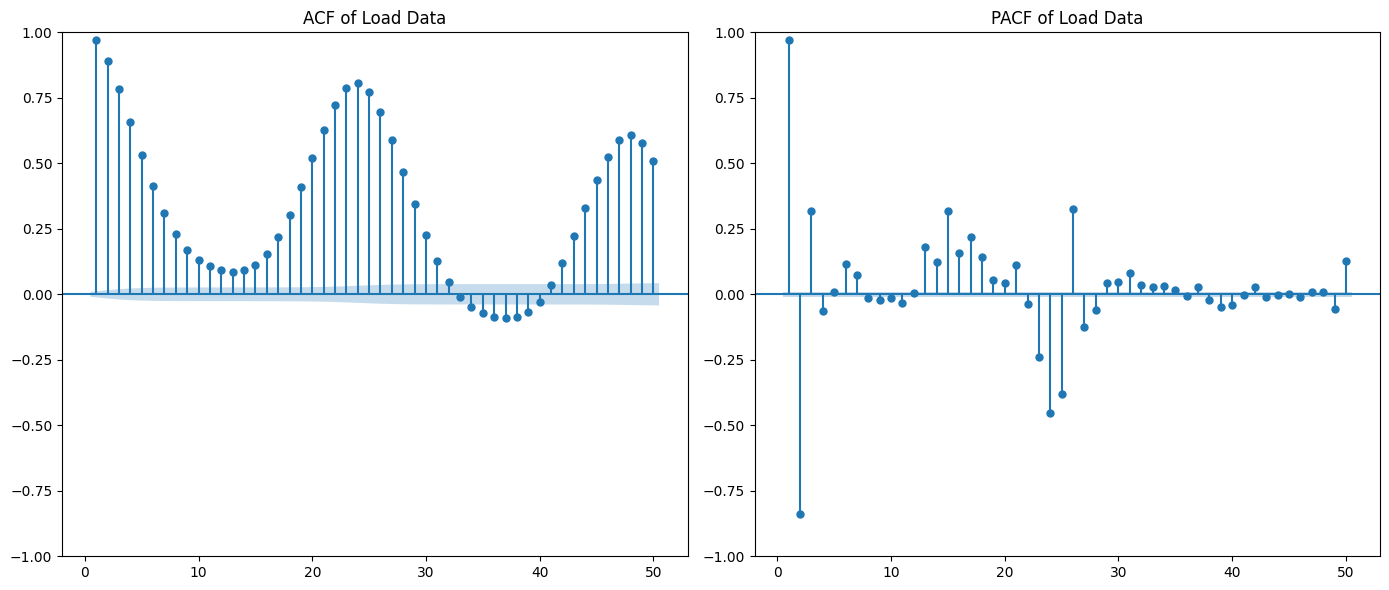

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

# ACF
plt.subplot(1, 2, 1)
plot_acf(df['load'], lags=50, zero=False, ax=plt.gca())
plt.title("ACF of Load Data")

# PACF
plt.subplot(1, 2, 2)
plot_pacf(df['load'], lags=50, zero=False, method='ywm', ax=plt.gca())
plt.title("PACF of Load Data")

plt.tight_layout()
plt.show()

## Implementation

Split the data and start the naive forecast model


In [19]:
# Split into train and test
train_size = int(len(load_data) * 0.8)
train, test = load_data[:train_size], load_data[train_size:]

In [23]:
# Define SARIMA parameters based on ACF/PACF analysis
p, d, q = 5, 0, 1  # Non-seasonal
P, D, Q, s = 1, 1, 1, 24  # Seasonal with daily period (24 hours)

# Define and fit the SARIMAX model on the training data
mod = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result_1 = mod.fit(disp=False)

# Summary of the fitted model
print(sarima_result_1.summary())


c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                26880
Model:             SARIMAX(5, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -215860.669
Date:                            Mon, 25 Nov 2024   AIC                         431739.339
Time:                                    17:22:00   BIC                         431813.123
Sample:                                         0   HQIC                        431763.139
                                          - 26880                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.6349      0.026    100.554      0.000       2.584       2.686
ar.L2         -2.5355      0.048   

In [25]:
from pmdarima import auto_arima

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Evaluation

[Clearly state what metrics you will use to evaluate the model's performance. These metrics will serve as a starting point for evaluating more complex models later on.]



In [24]:
# Make predictions on the test set
forecast = sarima_result_1.forecast(steps=len(test))
 # Calculate MAE
mae = mean_absolute_error(test, forecast)
# Calculate MAPE
mape = mean_absolute_percentage_error(test, forecast)

# Print MAPE
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
# Print MAE
print(f"Mean Absolute Error (MAE): {mae}")

c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Absolute Percentage Error (MAPE): 0.19765471294306508%
Mean Absolute Error (MAE): 9363.84032344372
